# Intro to Argovis' Grid API - EOF analysis example

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import math
import numpy as np
from datetime import datetime, timedelta
import scipy.io
import xarray as xr
API_KEY=''

import pandas as pd
import numpy.matlib 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests
from calendar import monthrange
import pickle as pkl
import sys
import statistics
import cartopy.crs as ccrs
import numpy.linalg as LA
import timeit
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
from scipy import signal
from matplotlib.gridspec import GridSpec


## Downloading Gridded Data

Argovis offers gridded data at its `/grids` endpoint. Available query string parameters are:

 - `gridName` (mandatory, one of rgTempTotal, rgPsalTotal, ohc): name of gridded product to search.
 - `startDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (mandatory, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `presRange` (optional, format minimum_pressure,maximum_pressure): pressure window to filter for.

As noted, `gridName`, `startDate`, `endDate` and `polygon` are all required for downloading gridded data, but we can get just the metadata record that describes some high-level information about each grid by providing only the `gridName` parameter:


In [2]:
params = {
  "gridName": 'rgTempTotal',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())

{'_id': 'rgTempTotal', 'units': 'degree celcius (ITS-90)', 'levels': [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 182.5, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 462.5, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1412.5, 1500, 1600, 1700, 1800, 1900, 1975], 'date_added': '2022-04-27T23:07:27.943Z', 'lonrange': [-179.5, 179.5], 'latrange': [-64.5, 79.5], 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'], 'loncell': 1, 'latcell': 1}


We see information about the Roemmich-Gilson Argo climatology, like what pressure levels are present, what the minimum and maximum of latitude, longitude and time is in the grid, and soforth.

Let's try a simple request to download a piece of data from this climatology, a 10 degree box over the North Atlantic from the first quarter of 2012:

In [4]:
params = {
    "gridName": 'ohc',
    "startDate": '2009-01-01T00:00:00Z',
    "endDate": '2019-01-01T00:00:00Z',
#    "polygon": '[[-180, -10], [-180, 10], [-170, 10], [-170, -10], [-180, -10]]'
    "polygon": '[[130, -10], [130, 10], [-80, 10], [-80, -10], [130, -10]]'
}
# [[lonmin,latmin],[lonmin,latmax],[lonmax,latmax],[lonmax,latmin],[lonmin,latmin]]

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata = r.json()

In [5]:
# params = {
#   "gridName": 'rgTempTotal',
#   "startDate": '2012-01-01T00:00:00Z',
#   "endDate": '2013-01-01T00:00:00Z',
#   "polygon": '[[-66.621094,42.163403],[-71.367188,40.580585],[-74.003906,37.439974],[-75.058594,35.029996],[-79.453125,32.249974],[-80.15625,29.993002],[-78.75,23.725012],[-73.828125,21.289374],[-70.3125,20.797201],[-67.5,19.47695],[-64.160156,19.47695],[-66.621094,42.163403]]'
# }

# r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
# rgdata = r.json()

Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

In [6]:
rgdata

[{'_id': 'ohc',
  'units': 'J/m^2',
  'levels': [15],
  'date_added': '2022-04-27T23:08:49.651Z',
  'lonrange': [-179.5, 179.5],
  'latrange': [-64.5, 64.5],
  'timerange': ['2005-01-31T00:00:00.000Z', '2020-12-31T00:00:00.000Z'],
  'loncell': 1,
  'latcell': 1},
 {'_id': '6264fcdbac3befad7c265dca',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-12-31T00:00:00.000Z',
  'd': [336280314424.48346]},
 {'_id': '6264fc9aac3befad7c25e8dd',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-11-30T00:00:00.000Z',
  'd': [336555646722.59076]},
 {'_id': '6264fc59ac3befad7c2573f0',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-10-31T00:00:00.000Z',
  'd': [336560198695.5379]},
 {'_id': '6264fc17ac3befad7c24ff03',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-09-30T00:00:00.000Z',
  'd': [336831760244.816]},
 {'_id': '6264fbd5ac3befad7c248a16',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2

The first object in a request to `/grids` is always the appropriate *metadata record* for the grid, the same as what you got from `/grids?gridName=rgTempTotal` above. We automatically include it at the front of the full data requests as it is necessary for interpreting that data, as we'll see immediately below.

All the records returned by `/grids` after the first specify the actual data we wanted; let's have a look at one of them:

By default, Argovis returns gridded data in a *profile-like* structure: this record, located in space by its `g` key (for geolocation) and time by its `t` key, contains the grid points for all corresponding depths in its `d` (for data) key. To interpret the list of numbers, compare it entry-by-entry to the `levels` key in the metadata record; for example, the two records printed above indicate that the temperature at these coordinates and 10 dbar depth is 25.118999.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [7]:
# def xargrid(grid):
#     # given the json response <grid> of a request to /grids,
#     # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
#     lat = []
#     lon = []
#     time = []
#     pres = []
#     meas = []
#     for p in grid[1:]:
#         for i, e in enumerate(p['d']):
#             lon.append(p['g']['coordinates'][0])
#             lat.append(p['g']['coordinates'][1])
#             # convert a string to a date (zeros to check at the end of date)
#             time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
#             meas.append(p['d'][i])
#             pres.append(grid[0]['levels'][i])
            
#     df = pd.DataFrame({"latitude": lat, 
#                            "longitude": lon, 
#                            "time": time, 
#                            "pressure": pres, 
#                            "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
#     return df.to_xarray()
    
# ds = xargrid(rgdata)

In [8]:
def xargrid(grid):
    # given the json response <grid> of a request to /grids,
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    pres = []
    meas = []
    for p in grid[1:]:
        for i, e in enumerate(p['d']):
            if p['g']['coordinates'][0]<0:
                lon.append(p['g']['coordinates'][0]+360)
            else:    
                lon.append(p['g']['coordinates'][0])
            lat.append(p['g']['coordinates'][1])
            # convert a string to a date (zeros to check at the end of date)
            time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            meas.append(p['d'][i])
            pres.append(grid[0]['levels'][i])
            
    df = pd.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pres, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds0 = xargrid(rgdata)

In [9]:
rgdata[1:][0]['g']['coordinates'][0]

-133.5

In [10]:
# dsshift=ds.roll(longitude=180,roll_coords=True)
# #dsshift2=dsshift
# shiftedlon=dsshift['longitude'].values
# shiftedlon[dsshift['longitude'].values<0]=dsshift['longitude'].values[dsshift['longitude'].values<0]+360
# #print(shiftedlon)
# dsshift.coords['longitude']=('longitude',shiftedlon)

In [29]:
time = ds.time.values

In [30]:
rgdata

[{'_id': 'ohc',
  'units': 'J/m^2',
  'levels': [15],
  'date_added': '2022-04-27T23:08:49.651Z',
  'lonrange': [-179.5, 179.5],
  'latrange': [-64.5, 64.5],
  'timerange': ['2005-01-31T00:00:00.000Z', '2020-12-31T00:00:00.000Z'],
  'loncell': 1,
  'latcell': 1},
 {'_id': '6264fcdbac3befad7c265dca',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-12-31T00:00:00.000Z',
  'd': [336280314424.48346]},
 {'_id': '6264fc9aac3befad7c25e8dd',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-11-30T00:00:00.000Z',
  'd': [336555646722.59076]},
 {'_id': '6264fc59ac3befad7c2573f0',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-10-31T00:00:00.000Z',
  'd': [336560198695.5379]},
 {'_id': '6264fc17ac3befad7c24ff03',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2018-09-30T00:00:00.000Z',
  'd': [336831760244.816]},
 {'_id': '6264fbd5ac3befad7c248a16',
  'g': {'type': 'Point', 'coordinates': [-133.5, 31.5]},
  't': '2

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [31]:
print('latitudes:',ds0['latitude'].data)
print('longitudes:',ds0['longitude'].data)
print('times:',ds0['time'].data)
print('pressures:',ds0['pressure'].data)

latitudes: [-33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5
 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5
  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5
   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5
  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5
  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5]
longitudes: [130.5 131.5 132.5 133.5 134.5 135.5 136.5 137.5 138.5 139.5 140.5 141.5
 142.5 143.5 144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5
 154.5 155.5 156.5 157.5 158.5 159.5 160.5 161.5 162.5 163.5 164.5 165.5
 166.5 167.5 168.5 169.5 170.5 171.5 172.5 173.5 174.5 175.5 176.5 177.5
 178.5 179.5 180.5 181.5 182.5 183.5 184.5 185.5 186.5 187.5 188.5 189.5
 190.5 191.5 192.5 193.5 194.5 195.5 196.5 197.5 198.5 199.5 200.5 201.5
 202.5 203.5 204.5 205.5 206.5 207.5 208.5 209.5 210.5 211.5 212.5 213.5
 214.5 215.5 216.5 217.5 218.5 219.5 220.5 221.5 22

We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

In [32]:
ds0

<xarray.Dataset>
Dimensions:      (latitude: 68, longitude: 150, pressure: 1, time: 120)
Coordinates:
  * latitude     (latitude) float64 -33.5 -32.5 -31.5 -30.5 ... 31.5 32.5 33.5
  * longitude    (longitude) float64 130.5 131.5 132.5 ... 277.5 278.5 279.5
  * time         (time) datetime64[ns] 2009-01-31 2009-02-28 ... 2018-12-31
  * pressure     (pressure) int64 15
Data variables:
    measurement  (latitude, longitude, time, pressure) float64 nan nan ... nan

In [33]:
min_lon = 130
min_lat = -10
max_lon = 280
max_lat = 10

mask_lon = (ds0.longitude >= min_lon) & (ds0.longitude <= max_lon)
mask_lat = (ds0.latitude >= min_lat) & (ds0.latitude <= max_lat)

ds = ds0.where(mask_lon & mask_lat, drop=True)

ds

<xarray.Dataset>
Dimensions:      (latitude: 20, longitude: 150, pressure: 1, time: 120)
Coordinates:
  * latitude     (latitude) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 6.5 7.5 8.5 9.5
  * longitude    (longitude) float64 130.5 131.5 132.5 ... 277.5 278.5 279.5
  * time         (time) datetime64[ns] 2009-01-31 2009-02-28 ... 2018-12-31
  * pressure     (pressure) int64 15
Data variables:
    measurement  (latitude, longitude, time, pressure) float64 nan nan ... nan

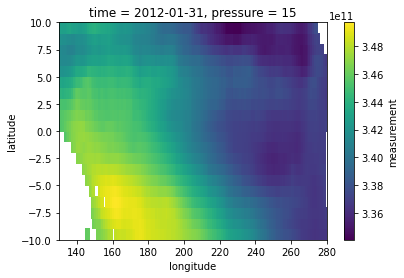

In [34]:
gridmap = ds.loc[{"time":'2012-01-31T00:00:00.000Z'}] #, "pressure":2.5}]
gridmap['measurement'].plot()

In [35]:
#nino 3.4 mask
min_lon = 190
max_lon = 240
min_lat = -5
max_lat = 5

mask_lon = (ds0.longitude >= min_lon) & (ds0.longitude <= max_lon)
mask_lat = (ds0.latitude >= min_lat) & (ds0.latitude <= max_lat)

n34 = ds0.where(mask_lon & mask_lat, drop=True)

#n34

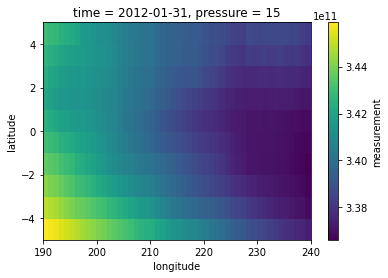

In [36]:
gridmap = n34.loc[{"time":'2012-01-31T00:00:00.000Z'}] #, "pressure":2.5}]
gridmap['measurement'].plot()

In [71]:
#Take mean across the whole region
n34OHC0=n34.mean(dim='latitude')
n34OHC=n34OHC0.mean(dim='longitude')
n34OHC=n34OHC-np.mean(n34OHC['measurement'])

In [39]:
#Take mean across the whole region
eqOHC0=ds.mean(dim='latitude')
eqOHC=eqOHC0.mean(dim='longitude')
eqOHC=eqOHC-np.mean(eqOHC['measurement'])

In [41]:
#load in Nino 34 data. This is my own you will need to do this yourself
ENSO341=np.load('/Users/willk/Documents/ATOC/Data/Climate Indices/ENSO34 array.npy' ,allow_pickle=True)
ENSO34=ENSO341[:,0,:] #I do this to remove SST and to keep dates and SST anomalies
# print(np.shape(ENSO34)) 
# ENSO34

(3, 476)


array([[datetime.datetime(1982, 1, 1, 0, 0),
        datetime.datetime(1982, 2, 1, 0, 0),
        datetime.datetime(1982, 3, 1, 0, 0), ...,
        datetime.datetime(2021, 8, 1, 0, 0),
        datetime.datetime(2021, 9, 1, 0, 0),
        datetime.datetime(2021, 10, 1, 0, 0)],
       [26.72, 26.7, 27.2, ..., 26.43, 26.44, 25.89],
       [0.15, -0.02, -0.02, ..., -0.44, -0.28, -0.83]], dtype=object)

In [87]:
#Find the start and end of the OHC data
print(time[0],time[-1])

2009-01-31T00:00:00.000000000 2018-12-31T00:00:00.000000000


In [51]:
#find the mathcing times in your Nino34 \
#note the OHC values at the end of the month should be the same for the Nino 3.4 at the start of the month
i=int(np.where(ENSO34[0,:]==datetime(2009, 1, 1, 0, 0))[0])
j=int(np.where(ENSO34[0,:]==datetime(2018, 12, 1, 0, 0))[0])
print(ENSO34[0,i],ENSO34[0,j])

2009-01-01 00:00:00 2018-12-01 00:00:00


In [52]:
#take a subset of your Nino 34 data to match the OHC for ease of use
dates34 = ENSO34[0,i:j]
nino34 = ENSO34[2,i:j]

In [55]:
#remove mean monthly signals
climatology = eqOHC.groupby('time.month').mean('time')

eqOHCa = eqOHC.groupby('time.month') - climatology

In [72]:
climatology2 = n34OHC.groupby('time.month').mean('time')

n34OHCa = n34OHC.groupby('time.month') - climatology2

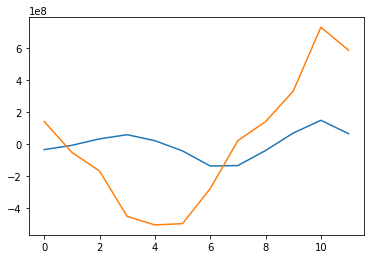

In [88]:
#look at climatology
plt.plot(climatology['measurement'])
plt.plot(climatology2['measurement'])

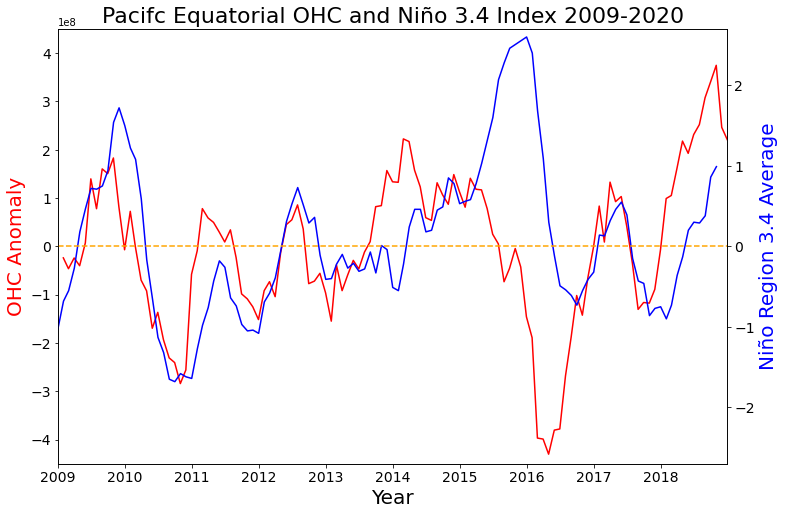

In [86]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12,8))
# make a plot
plt.title('Pacifc Equatorial OHC and Niño 3.4 Index 2009-2020', fontsize=22)
ax.plot(time,eqOHCa['measurement'], color="red")
# set x-axis label
ax.set_xlabel("Year",fontsize=20)
plt.ylim([-4.5e8,4.5e8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# set y-axis label
ax.set_ylabel("OHC Anomaly",color="red",fontsize=20)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dates34,nino34,color="blue")
ax2.set_ylabel("Niño Region 3.4 Average",color="blue",fontsize=20)
plt.ylim([-2.7,2.7])
plt.yticks(fontsize=14)
plt.axhline(y=0, color='orange',linestyle='--')
plt.xlim(dates34[0],time[-1])
plt.show()

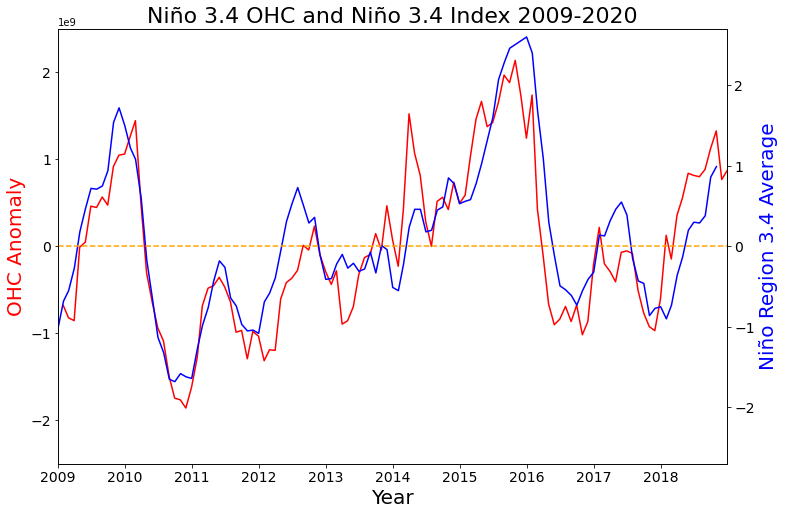

In [89]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12,8))
# make a plot
plt.title('Niño 3.4 OHC and Niño 3.4 Index 2009-2020', fontsize=22)
ax.plot(time,n34OHCa['measurement'], color="red")
# set x-axis label
ax.set_xlabel("Year",fontsize=20)
plt.ylim([-2.5e9,2.5e9])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# set y-axis label
ax.set_ylabel("OHC Anomaly",color="red",fontsize=20)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dates34,nino34,color="blue")
ax2.set_ylabel("Niño Region 3.4 Average",color="blue",fontsize=20)
plt.ylim([-2.7,2.7])
plt.yticks(fontsize=14)
plt.axhline(y=0, color='orange',linestyle='--')
plt.xlim(dates34[0],time[-1])
plt.show()

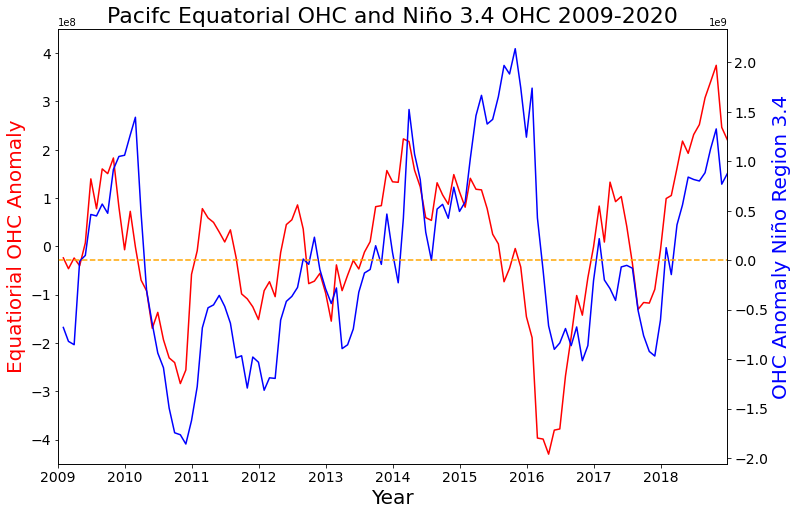

In [91]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12,8))
# make a plot
plt.title('Pacifc Equatorial OHC and Niño 3.4 OHC 2009-2020', fontsize=22)
ax.plot(time,eqOHCa['measurement'], color="red")
# set x-axis label
ax.set_xlabel("Year",fontsize=20)
plt.ylim([-4.5e8,4.5e8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# set y-axis label
ax.set_ylabel("Equatiorial OHC Anomaly",color="red",fontsize=20)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(time,n34OHCa['measurement'],color="blue")
ax2.set_ylabel("OHC Anomaly Niño Region 3.4",color="blue",fontsize=20)
#plt.ylim([-2.7,2.7])
plt.yticks(fontsize=14)
plt.axhline(y=0, color='orange',linestyle='--')
plt.xlim(dates34[0],time[-1])
plt.show()